In [209]:
import numpy as np
import os
import cv2
import math

import matplotlib.pyplot as plt

In [210]:
source_path = os.path.join('data', 'ara.png')
source = cv2.imread(source_path)
source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)

<Axes: title={'center': 'Исходник'}>

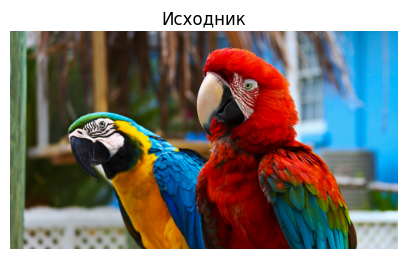

In [211]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 7)
ax.imshow(source)
ax.set_title('Исходник')
ax.set_axis_off()
ax

In [212]:
print(f'image size is {source.shape}, image weight is {source.nbytes} bytes')

image size is (554, 987, 3), image weight is 1640394 bytes


In [213]:
source[0, 0, :]

array([ 84, 108,  80], dtype=uint8)

### шаг 1: конвертация цветового пространства | step 1: color space convertation

In [245]:
def RGB2YCrCb(source:np.ndarray)->np.ndarray:
    '''
    переводит изображение из формата RGB в формат YCrCb,
    где:
    Y - Яркость
    Cr - Хроматический красный
    Cb - Хроматический синий
    transforms RGB to YCrCb format
    '''
    # matrix = np.array([
    #     [0.299, 0.587, 0.114],
    #     [0.5, -0.4187, -0.0813],
    #     [0.1687, -0.3313, 0.5]
    # ])

    matrix = np.array([
        [0.2126*(219/255), 0.7152*(219/255), 0.0722*(219/255)],
        [-(0.2126/1.8556)*(224/255), -(0.7152/1.8556)*(224/255), 0.5*(224/255)],
        [0.5*(224/255), -(0.7152/1.5748)*(224/255), -(0.0722/1.5748)*(224/255)]
    ])
    
    bias = np.array([16, 128, 128])
    dst = np.zeros((source.shape[0], source.shape[1], 3))
    for i in range(source.shape[0]):
        for j in range(source.shape[1]):
            dst[i][j] = matrix@source[i][j]+bias
    # dst = matrix@source+bias
    dst -= dst.min()
    dst /= dst.max()
    dst*=255.
    # print(dst.min())
    # print(dst.max())
    
    return dst.astype(np.uint8)
    # return dst

def YCrCb2RGB(source:np.ndarray)->np.ndarray:
    ''''''
    matrix = np.array([
        [1, 0, 1.402],
        [1, -0.33414, -0.71414],
        [1, 1.772, 0]
    ])
    bias = np.array([0, 128, 128])
    dst = np.zeros((source.shape[0], source.shape[1], 3))
    for i in range(source.shape[0]):
        for j in range(source.shape[1]):
            dst[i][j] = matrix@(source[i][j]-bias)
    dst -= dst.min()
    dst /= dst.max()
    dst*=255.
    
    return dst.astype(np.uint8)
    # return dst
    

[ 84 108  80]
[101 126  96]


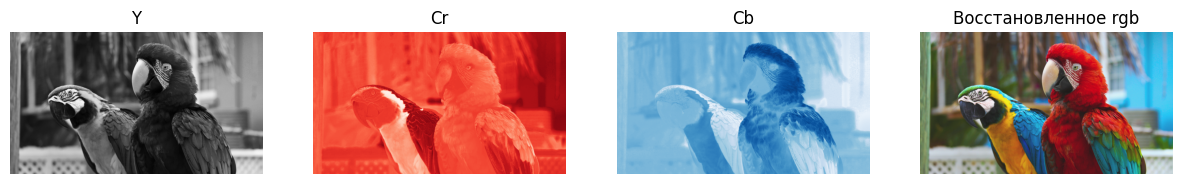

In [246]:
YCrCb = RGB2YCrCb(source)
rgb = YCrCb2RGB(YCrCb)
fig, ax = plt.subplots(1, 4)
titles = ['Y', 'Cr', 'Cb']
cmaps = ['gray', 'Reds', 'Blues']
fig.set_size_inches(15, 4)
for i in range(3):
    ax[i].imshow(YCrCb[:, :, i], cmap = cmaps[i])
    ax[i].set_title(titles[i])
    ax[i].set_axis_off()

print(source[0][0])
print(rgb[0][0])
ax[3].imshow(rgb)
ax[3].set_title('Восстановленное rgb')
ax[3].set_axis_off()
    

### шаг 2: понижение размерности цветовых каналов | step 2: downsapling color channels

In [226]:
def make_multiple_of_16(source:np.ndarray)->np.ndarray:
    '''
    приводит изображение к размерности, кратной 16, для упрощения в учебных целях
    transform image to multiple-of-16 dimension for simplify in study goals
    '''
    h, w = source.shape[:2]
    multiplier_h = math.ceil(h/16)
    multiplier_w = math.ceil(w/16)
    return cv2.resize(source.copy(), (multiplier_w*16, multiplier_h*16))
    
def get_every_second(source:np.ndarray)->np.ndarray:
    '''
    берет каждое второе значение по двум размерностям
    get every second value from two dimensions
    '''
    compressed = source[::2, ::2].copy()
    return compressed

YCrCb = make_multiple_of_16(YCrCb)
Cr_compressed = get_every_second(YCrCb[:, :, 1])
Cb_compressed = get_every_second(YCrCb[:, :, 2])
Cr_compressed.shape


(280, 496)

In [227]:
def restore_img(compressed:np.ndarray, shape:tuple[int, int])->np.ndarray:
    '''
    восстанавливает изображения из пониженной размерности шага 2
    restores image from compressed one from step 2
    '''
    restored = np.repeat(compressed, 2, axis = 0).copy()
    restored = np.repeat(restored, 2, axis = 1)
    return restored[:shape[0], :shape[1]]
Cr_restored = restore_img(Cr_compressed, YCrCb[:, :, 0].shape)
Cb_restored = restore_img(Cb_compressed, YCrCb[:, :, 0].shape)
Cb_restored.shape

(560, 992)

In [228]:
YCrCb_restored = np.stack((YCrCb[:, :, 0].copy(),  Cr_restored, Cb_restored), axis = -1)
YCrCb_restored.shape

(560, 992, 3)

In [229]:
print(f'images weight relation already is {(YCrCb[:, :, 0].copy().nbytes+Cr_compressed.nbytes+Cb_compressed.nbytes)/source.nbytes}')

images weight relation already is 0.5079755229536319


In [230]:
Cr_restored = np.repeat(Cr_compressed, 2, axis =0)
Cr_restored = np.repeat(Cr_restored, 2, axis = 1)
Cr_restored[:, :]

array([[116, 116, 116, ..., 176, 176, 176],
       [116, 116, 116, ..., 176, 176, 176],
       [112, 112, 113, ..., 177, 175, 175],
       ...,
       [106, 106, 105, ..., 132, 132, 132],
       [104, 104, 105, ..., 132, 132, 132],
       [104, 104, 105, ..., 132, 132, 132]], shape=(560, 992), dtype=uint8)

### шаг 3: ДКП | step 3: DCT

D = C@S@C.T

S = C.T@D@C

In [231]:
N = 8
def get_dct_II_matrix(N:int):
    """базис дискретного косинусного преобразования 2-го типа"""
    dct = np.zeros((N, N))
    for n in range(N):
        dct[0][n] = math.sqrt(1/N)
    for m in range(1, N):
        for n in range(N):
            dct[m][n]=math.sqrt(2/N)*math.cos((2*n+1)*math.pi*m/(2*N))
    return dct

dct = get_dct_II_matrix(N)

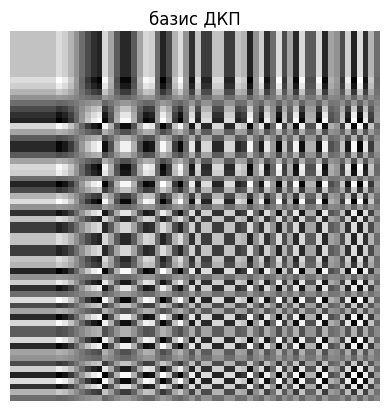

In [232]:
def get_base_image(N:int)->np.ndarray:
    '''
    возвращает изображение базиса ДКП для NxN точек
    returns basis DCT images
    '''
    dct = get_dct_II_matrix(N)
    base=np.zeros((N*N,N*N))
    for i in range(N):
        for j in range(N):
            pos_m=i*N
            pos_n=j*N
            DCT_v=dct[i,:].reshape(-1,1)
            DCT_T_h=dct.T[:,j].reshape(-1,N)
            base[pos_m:pos_m+N,pos_n:pos_n+N]=DCT_v@DCT_T_h
    base+=np.absolute(base.min())
    scale=np.around(1/base.max(),decimals=3)
    for i in range(base.shape[0]):
        for j in range(base.shape[1]):
            base[i][j]=np.around(base[i][j]*scale,decimals=3)
    return base

base = get_base_image(N)
plt.axis('off')
plt.title('базис ДКП')
plt.imshow(base, cmap = 'gray', vmin = 0)

In [233]:
def build_snake_matrix(size:int):
    '''build example matrix'''
    steps = 2*size-1
    matrix = [[0]*size for _ in range(size)]
    number = 0
    for k in range(steps):
        if k%2==1:
            j = min(k, size-1)
            i = k-j
            while j>=0 and i<size:
                matrix[i][j] = number
                number+=1
                j-=1
                i+=1
        else:
            i = min(k, size-1)
            j = k-i
            while i>=0 and j<size:
                matrix[i][j] = number
                number+=1
                j+=1
                i-=1
    return np.array(matrix)
            

def get_snake_mask(count:int, size:int)->list:
    '''get elements in `snake` order'''
    if count>=size**2: return np.ones((size, size))
    mask = np.zeros((size, size))
    i, j = 0, 0
    for k in range(count):
        if k==0: 
            mask[i][j] = 1
        else:
            if (i+j)%2==0:
                i = max(i-1, 0)
                j = min(j+1, size-1)
            else:
                i = min(i+1, size-1)
                j = max(j-1, 0)
            mask[i][j] = 1
    return mask
            
snake = build_snake_matrix(N)
print(snake)
mask = get_snake_mask(15, N)
print(snake*mask)

[[ 0  1  5  6 14 15 27 28]
 [ 2  4  7 13 16 26 29 42]
 [ 3  8 12 17 25 30 41 43]
 [ 9 11 18 24 31 40 44 53]
 [10 19 23 32 39 45 52 54]
 [20 22 33 38 46 51 55 60]
 [21 34 37 47 50 56 59 61]
 [35 36 48 49 57 58 62 63]]
[[ 0.  1.  5.  6. 14.  0.  0.  0.]
 [ 2.  4.  7. 13.  0.  0.  0.  0.]
 [ 3.  8. 12.  0.  0.  0.  0.  0.]
 [ 9. 11.  0.  0.  0.  0.  0.  0.]
 [10.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


Text(0.5, 1.0, 'первый')

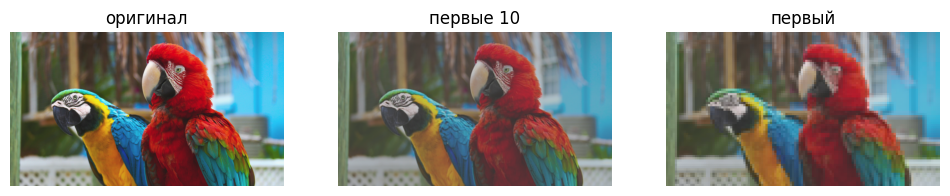

In [234]:
def compress(img, mask, N):
    '''сжатие изображения за счёт выбора более информативных измерений'''
    C = get_dct_II_matrix(N)
    img_compressed = np.zeros((img.shape[0]//N*N, img.shape[1]//N*N))
    for i in range(0, img_compressed.shape[0], N):
        for j in range(0, img_compressed.shape[1], N):
            block=img[i:i+N,j:j+N].copy()
            # DCT            
            coeff=C@block@(C.T)
            block = coeff*mask
            img_compressed[i:i+N,j:j+N]=block
    return img_compressed

def dct2orig(img_compressed, N):
    '''операция, обратная к ДКП'''
    C = get_dct_II_matrix(N)
    channel = np.zeros((img_compressed.shape[0]//N*N, img_compressed.shape[1]//N*N))
    for i in range(0, img_compressed.shape[0], N):
        for j in range(0, img_compressed.shape[1], N):
            block = img_compressed[i:i+N,j:j+N].copy()
            y_block=(C.T)@block@C
            channel[i:i+N,j:j+N]=y_block
    return channel

def reduce_high_freqs(orig_img:np.ndarray, N, first)->np.ndarray:
    '''
    orig_img - YCrCb
    '''
    Y = YCrCb[:, :, 0].copy()
    Cr_divided = get_every_second(YCrCb[:, :, 1])
    Cb_divided = get_every_second(YCrCb[:, :, 2])

    snake_mask = get_snake_mask(first, N)

    Y_compressed = compress(Y, snake_mask, N)
    Cr_compressed = compress(Cr_divided, snake_mask, N)
    Cb_compressed = compress(Cb_divided, snake_mask, N)

    Y_orig = dct2orig(Y_compressed, N)
    Cr_orig = dct2orig(Cr_compressed, N)
    Cb_orig = dct2orig(Cb_compressed, N)

    Cr_restored = restore_img(Cr_orig, YCrCb[:, :, 0].shape)
    Cb_restored = restore_img(Cb_orig, YCrCb[:, :, 0].shape)

    YCrCb_restored = np.stack((Y_orig,  Cr_restored, Cb_restored), axis = -1)
    return YCrCb_restored

YCrCb_10 = reduce_high_freqs(YCrCb, N, 10)
YCrCb_1 = reduce_high_freqs(YCrCb, N, 1)


fig, ax = plt.subplots(1, 3)
fig.set_size_inches((12, 4))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

ax[0].imshow(YCrCb2RGB(YCrCb))
ax[1].imshow(YCrCb2RGB(YCrCb_10))
ax[2].imshow(YCrCb2RGB(YCrCb_1))

ax[0].set_title('оригинал')
ax[1].set_title('первые 10')
ax[2].set_title('первый')

In [248]:
def reshape2lines(img_compressed:np.ndarray)->np.ndarray:
    blocks = []
    for i in range(0, img_compressed.shape[0], N):
        for j in range(0, img_compressed.shape[1], N):
            block = img_compressed[i:i+N,j:j+N].copy()
            blocks.append(block)
    return np.array(blocks)
reshaped = reshape2lines(compressed_Y_30)
# print(reshaped.shape)
# print(reshaped[0])
# reshaped = compressed_Y_30
# reshaped[:N, :N]
# print(compressed_Y_30.shape)
reshaped = compressed_Y_30.reshape((-1, N, compressed_Y_30.shape[1]), order = 'C') # (69, 8, 123*8)
reshaped = reshaped.reshape((-1, N, compressed_Y_30.shape[1]//N, N), order = 'C') # (69, 8, 123, 8)
reshaped = np.moveaxis(reshaped, 1, 2).reshape((-1, N, N)) # (69, 123, 8, 8) -> (8487, 8, 8)
# print(reshaped[0])

def flatten_snake(block:np.ndarray):
    '''спрямляет блок в `змеином` порядке'''
    size = block.shape[0]
    steps = 2*size-1
    flatten = []
    for k in range(steps):
        if k%2==1:
            j = min(k, size-1)
            i = k-j
            while j>=0 and i<size:
                flatten.append(block[i][j])
                j-=1
                i+=1
        else:
            i = min(k, size-1)
            j = k-i
            while i>=0 and j<size:
                flatten.append(block[i][j])
                j+=1
                i-=1
    return np.array(flatten)

flatten = flatten_snake(reshaped[0])

In [249]:
print(flatten)

[ 9.14750000e+02  2.29850932e+00 -4.17968947e+00 -1.41864835e+00
 -6.46558222e+00 -4.55955713e+01 -3.65018368e+00 -9.07823180e+00
 -2.34332822e+00 -1.24840069e+00 -1.25000000e+00 -9.49083464e-01
 -2.61243687e+00 -1.23183004e+00 -7.00000000e+00  1.01631462e-01
 -4.69468735e-01  5.20139942e-01  1.71260126e-01 -3.72212623e-01
  8.81815066e-01 -2.11835712e+00 -9.98244566e-01 -5.57610624e-01
 -1.18350862e+00  2.82768129e+00 -6.00797013e-01 -3.26157543e-01
  8.76645062e-02  5.47202181e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000

In [285]:
def compress_line(flat:list[int])->list[str]:
    '''flat->hex->str->compress'''
    hexed = list(map(hex, flat))
    string = [str(el)[2:] for el in hexed]
    start = 0
    end = 1
    positions = []
    while end < len(string):
        if string[start]!='0':
            start+=1
            end+=1
        
        if string[end] != '0':
            positions.append([start, end-1])
            start = end
        else:
            if end == len(string)-1: 
                positions.append([start, end])
        end+=1
    new_line = []
    for i in range(len(positions)):
        if i == 0:
            new_line.extend(string[:positions[0][0]])
            continue
        if i == len(positions)-1:
            new_line.extend(string[positions[-1][1]+1:])
        new_line.append('0x'+str(positions[i][1]-positions[i][0]+1))
        new_line.extend(string[positions[i-1][1]:positions[i][0]])
    # print(string)
    # print(positions)
    return new_line
            

In [286]:
z = np.zeros(N**2, dtype = np.uint8)
z[3] = 128
z[4] = 211
z[10] = 110
z[11] = 101
z[60] = 163
print(z)

new_line = compress_line(list(z))
print(new_line)

[  0   0   0 128 211   0   0   0   0   0 110 101   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 163   0   0   0]
['0x5', '0', '80', 'd3', '0x48', '0', '6e', '65', '0x3', '0', 'a3']
